# Import Packages

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns

from modules.dolphin_patterns import DolphinMatcher, DOLPHIN_PATTERNS
from modules.feature_extraction import compute_phonics_features, compute_structural_features
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


# Load and Overview Datasets

In [21]:
# Datasets: https://www.kaggle.com/datasets/gtkcyber/dga-dataset/data
df = pd.read_csv('./datasets/dga_data_20000.csv')
df

,isDGA,domain,host,subclass
0,legit,codepen,codepen.io,alexa
1,dga,d0a7gdrj18dr1lbobru1alnvd7,d0a7gdrj18dr1lbobru1alnvd7.com,newgoz
2,dga,songslept,songslept.net,nivdort
3,dga,bxbbldehppqnpwc,bxbbldehppqnpwc.ru,cryptolocker
4,legit,thunderbot,thunderbot.gg,alexa
...,...,...,...,...
19995,legit,lifehacker,lifehacker.com,alexa
19996,legit,iflashbuy,iflashbuy.com,alexa
19997,dga,cvhpyrxuqcfuccs,cvhpyrxuqcfuccs.ru,cryptolocker
19998,dga,wsvnjmhgurp,wsvnjmhgurp.tj,necurs


In [22]:
df.describe()

,isDGA,domain,host,subclass
count,20000,19999,20000,20000
unique,2,19999,19988,9
top,legit,codepen,parts-express.com,alexa
freq,10000,1,2,5336


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   isDGA     20000 non-null  object
 1   domain    19999 non-null  object
 2   host      20000 non-null  object
 3   subclass  20000 non-null  object
dtypes: object(4)
memory usage: 625.1+ KB


# Preprocessing datasets

#### Remove NaN

In [24]:
df.isna().sum()

isDGA       0
domain      1
host        0
subclass    0
dtype: int64

In [25]:
df.dropna()


,isDGA,domain,host,subclass
0,legit,codepen,codepen.io,alexa
1,dga,d0a7gdrj18dr1lbobru1alnvd7,d0a7gdrj18dr1lbobru1alnvd7.com,newgoz
2,dga,songslept,songslept.net,nivdort
3,dga,bxbbldehppqnpwc,bxbbldehppqnpwc.ru,cryptolocker
4,legit,thunderbot,thunderbot.gg,alexa
...,...,...,...,...
19995,legit,lifehacker,lifehacker.com,alexa
19996,legit,iflashbuy,iflashbuy.com,alexa
19997,dga,cvhpyrxuqcfuccs,cvhpyrxuqcfuccs.ru,cryptolocker
19998,dga,wsvnjmhgurp,wsvnjmhgurp.tj,necurs


In [26]:
df.drop(['domain'], axis=1, inplace=True)
df

,isDGA,host,subclass
0,legit,codepen.io,alexa
1,dga,d0a7gdrj18dr1lbobru1alnvd7.com,newgoz
2,dga,songslept.net,nivdort
3,dga,bxbbldehppqnpwc.ru,cryptolocker
4,legit,thunderbot.gg,alexa
...,...,...,...
19995,legit,lifehacker.com,alexa
19996,legit,iflashbuy.com,alexa
19997,dga,cvhpyrxuqcfuccs.ru,cryptolocker
19998,dga,wsvnjmhgurp.tj,necurs


#### Remove domains without public suffix

In [27]:
import tldextract

def has_valid_suffix(domain):
    ext = tldextract.extract(domain)
    return bool(ext.suffix)

df['valid_suffix'] = df['host'].apply(has_valid_suffix)
df = df[df['valid_suffix'] == True]
df.drop(['valid_suffix'], axis=1, inplace=True)


/var/folders/6y/n80cl3gj0xq_pd6830b445j80000gn/T/ipykernel_9311/3995567516.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['valid_suffix'], axis=1, inplace=True)


#### Remove duplicate domains

In [28]:
df.drop_duplicates(subset=['host'], inplace=True)

/var/folders/6y/n80cl3gj0xq_pd6830b445j80000gn/T/ipykernel_9311/2828493815.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset=['host'], inplace=True)


<Axes: xlabel='count', ylabel='isDGA'>

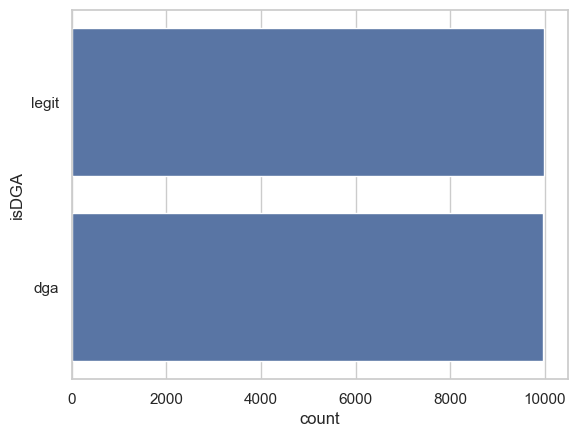

In [29]:
sns.countplot(df['isDGA'])

<Axes: xlabel='count', ylabel='subclass'>

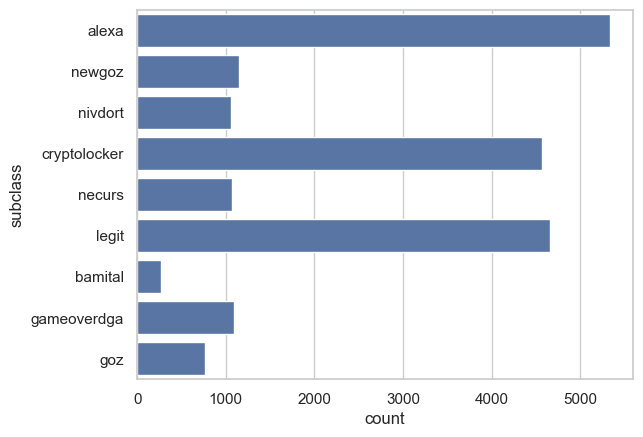

In [30]:
sns.countplot(df['subclass'])

# Label Encoding

In [31]:
df['isDGA'] = df['isDGA'].map({'dga': 1, 'legit': 0})
df

/var/folders/6y/n80cl3gj0xq_pd6830b445j80000gn/T/ipykernel_9311/1906653878.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['isDGA'] = df['isDGA'].map({'dga': 1, 'legit': 0})


,isDGA,host,subclass
0,0,codepen.io,alexa
1,1,d0a7gdrj18dr1lbobru1alnvd7.com,newgoz
2,1,songslept.net,nivdort
3,1,bxbbldehppqnpwc.ru,cryptolocker
4,0,thunderbot.gg,alexa
...,...,...,...
19995,0,lifehacker.com,alexa
19996,0,iflashbuy.com,alexa
19997,1,cvhpyrxuqcfuccs.ru,cryptolocker
19998,1,wsvnjmhgurp.tj,necurs


# Extract Features

In [32]:
# Initialize the DolphinMatcher
dolphin_matcher = DolphinMatcher(DOLPHIN_PATTERNS)

# List to store features
features = []

# Iterate over rows in the DataFrame
for _, row in df.iterrows():
    # Extract the domain name
    domain = row["host"]
    
    # Apply the DOLPHIN matching function to the domain name
    matches = dolphin_matcher.construct_output_function(domain)
    
    # Compute phonics features
    phonics_features = compute_phonics_features(matches)
    
    # Compute structural/statistical features
    structural_features = compute_structural_features(domain)
    
    # Combine all features into one dictionary
    all_features = {**phonics_features, **structural_features}
    
    # Add label to features
    all_features["isDGA"] = row["isDGA"]
    
    # Append to features list
    features.append(all_features)

# Convert the features list to a DataFrame
features_df = pd.DataFrame(features)

# Display the resulting DataFrame
features_df

,vowel_ratio,consonant_ratio,neutral_ratio,pattern_diversity,max_pattern_length,weighted_vowel_ratio,weighted_consonant_ratio,normalized_pattern_diversity,length,subdomain_count,entropy,isDGA
0,0.500000,0.400000,0.100000,0.300000,1,0.500000,0.400000,1.0,10,1,2.921928,0
1,0.192308,0.500000,0.307692,0.115385,2,0.200000,0.533333,1.0,30,1,3.989898,1
2,0.272727,0.636364,0.090909,0.272727,2,0.230769,0.692308,1.0,13,1,3.085055,1
3,0.117647,0.823529,0.058824,0.176471,2,0.111111,0.833333,1.0,18,1,3.641604,1
4,0.300000,0.600000,0.100000,0.300000,2,0.307692,0.615385,1.0,13,1,3.392747,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19950,0.416667,0.500000,0.083333,0.250000,2,0.428571,0.500000,1.0,14,1,3.521641,0
19951,0.363636,0.545455,0.090909,0.272727,2,0.307692,0.615385,1.0,13,1,3.700440,0
19952,0.166667,0.777778,0.055556,0.166667,1,0.166667,0.777778,1.0,18,1,3.350209,1
19953,0.076923,0.846154,0.076923,0.230769,2,0.142857,0.785714,1.0,14,1,3.664498,1


# Train model

### Separate features and labels

In [33]:
X = features_df.drop('isDGA', axis=1)
y = features_df['isDGA']

### Create a pipeline for scaling and classification

In [34]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(         
        n_estimators=100,
        random_state=42,
        class_weight='balanced',
        max_depth=None,
        min_samples_split=5
    ))
])

### Perform 5-fold cross-validation

In [35]:
cross_val_scores = cross_val_score(pipeline, X, y, cv=5)
print("Cross-validation scores:", cross_val_scores)
print("Average cross-validation score:", np.mean(cross_val_scores))

Cross-validation scores: [0.88148334 0.88524179 0.89050363 0.88824856 0.88900025]
Average cross-validation score: 0.8868955149085442


### Train-test split for final evaluation

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [37]:
# Detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# FPR and FNR
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
fpr = fp / (fp + tn)
fnr = fn / (tp + fn)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")

# Feature importance
rf_classifier = pipeline.named_steps['classifier']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_classifier.feature_importances_
}).sort_values(by='importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)



Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1998
           1       0.91      0.85      0.88      1993

    accuracy                           0.88      3991
   macro avg       0.89      0.88      0.88      3991
weighted avg       0.89      0.88      0.88      3991


Confusion Matrix:
[[1833  165]
 [ 301 1692]]

Accuracy: 0.8832
False Positive Rate (FPR): 0.0826
False Negative Rate (FNR): 0.1510

Feature Importance:
                         feature  importance
3              pattern_diversity    0.176630
0                    vowel_ratio    0.174767
10                       entropy    0.143860
8                         length    0.117413
1                consonant_ratio    0.117219
5           weighted_vowel_ratio    0.116785
6       weighted_consonant_ratio    0.068345
2                  neutral_ratio    0.066780
4             max_pattern_length    0.014838
9                subdomain_count    0.003164
7

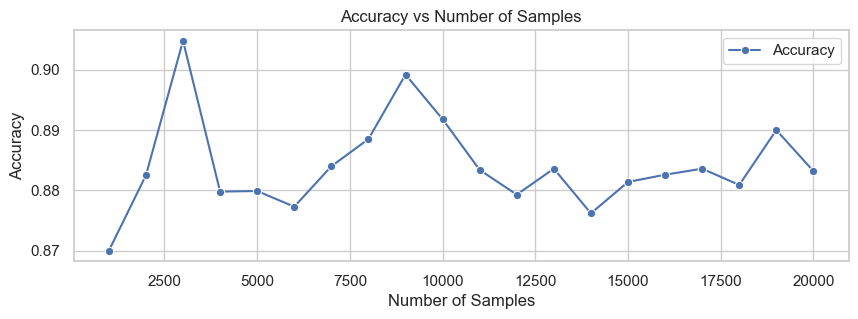

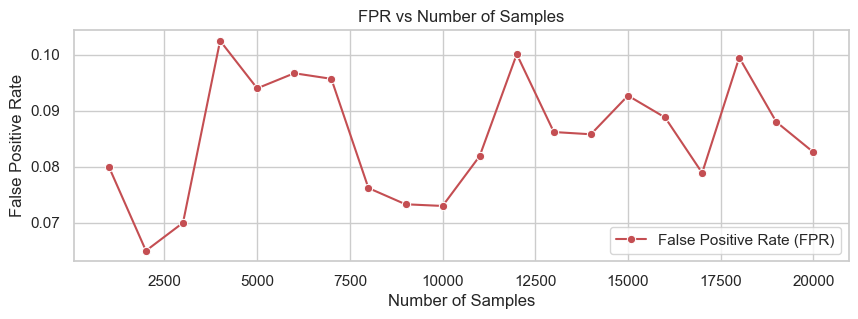

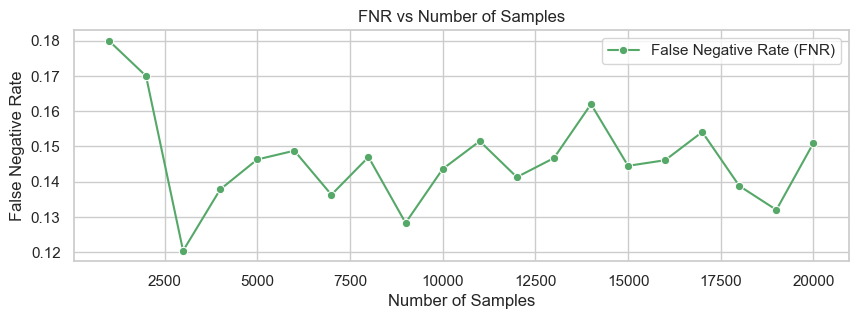

In [38]:
import matplotlib.pyplot as plt

data = {
    'Samples': [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000],
    'Accuracy': [0.8700, 0.8825, 0.9048, 0.8798, 0.8799, 0.8773, 0.8840, 0.8885, 0.8992, 0.8918, 0.8834, 0.8793, 0.8836, 0.8762, 0.8814, 0.8826, 0.8836, 0.8809, 0.8900, 0.8832],
    'FPR': [0.0800, 0.0650, 0.0700, 0.1025, 0.0940, 0.0967, 0.0957, 0.0762, 0.0733, 0.0730, 0.0819, 0.1001, 0.0862, 0.0858, 0.0927, 0.0888, 0.0789, 0.0995, 0.0880, 0.0826],
    'FNR': [0.1800, 0.1700, 0.1204, 0.1378, 0.1463, 0.1488, 0.1363, 0.1470, 0.1283, 0.1436, 0.1515, 0.1413, 0.1467, 0.1620, 0.1445, 0.1461, 0.1541, 0.1388, 0.1320, 0.1510]
}

df = pd.DataFrame(data)

sns.set(style="whitegrid")

plt.figure(figsize=(10, 3))
sns.lineplot(x='Samples', y='Accuracy', data=df, marker='o', color='b', label='Accuracy')
plt.title('Accuracy vs Number of Samples')
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 3))
sns.lineplot(x='Samples', y='FPR', data=df, marker='o', color='r', label='False Positive Rate (FPR)')
plt.title('FPR vs Number of Samples')
plt.xlabel('Number of Samples')
plt.ylabel('False Positive Rate')
plt.legend()
plt.show()

plt.figure(figsize=(10, 3))
sns.lineplot(x='Samples', y='FNR', data=df, marker='o', color='g', label='False Negative Rate (FNR)')
plt.title('FNR vs Number of Samples')
plt.xlabel('Number of Samples')
plt.ylabel('False Negative Rate')
plt.legend()
plt.show()
